In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
classA = np.load("object_1.npy")
classB = np.load("object_2.npy")
sample_val = np.load("sample.npy")

In [5]:
print(classA.shape)
print(classB.shape)
print(sample_val.shape)

(1000, 40, 60)
(1000, 40, 60)
(200, 40, 60)


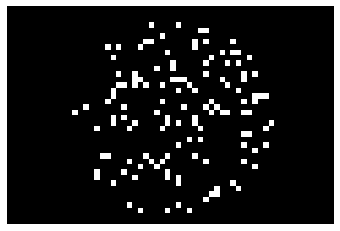

In [6]:
plt.imshow(classA[100], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

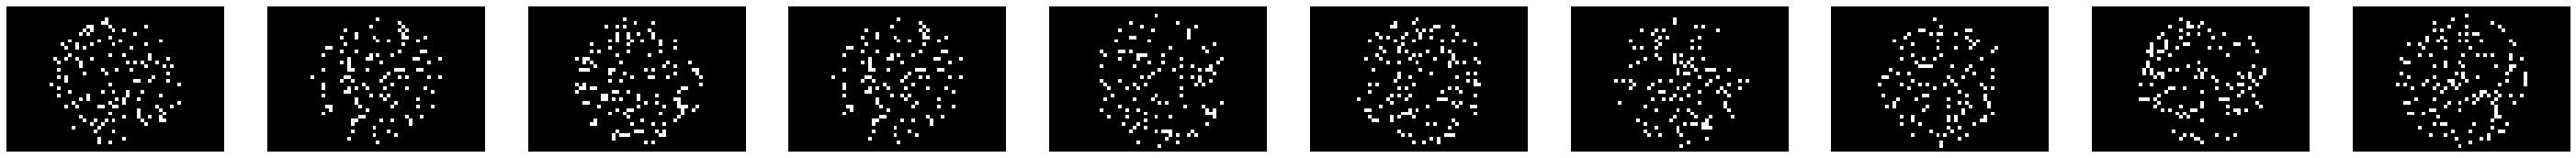

In [7]:
n = 10
f, axes = plt.subplots(1, n, figsize=(50, 60))
for i in range(n):
    index = random.randint(0, 1000)
    axes[i].imshow(classA[index], cmap='gray', interpolation='nearest')
    axes[i].axis('off')
    
plt.show()

IndexError: index 1000 is out of bounds for axis 0 with size 1000

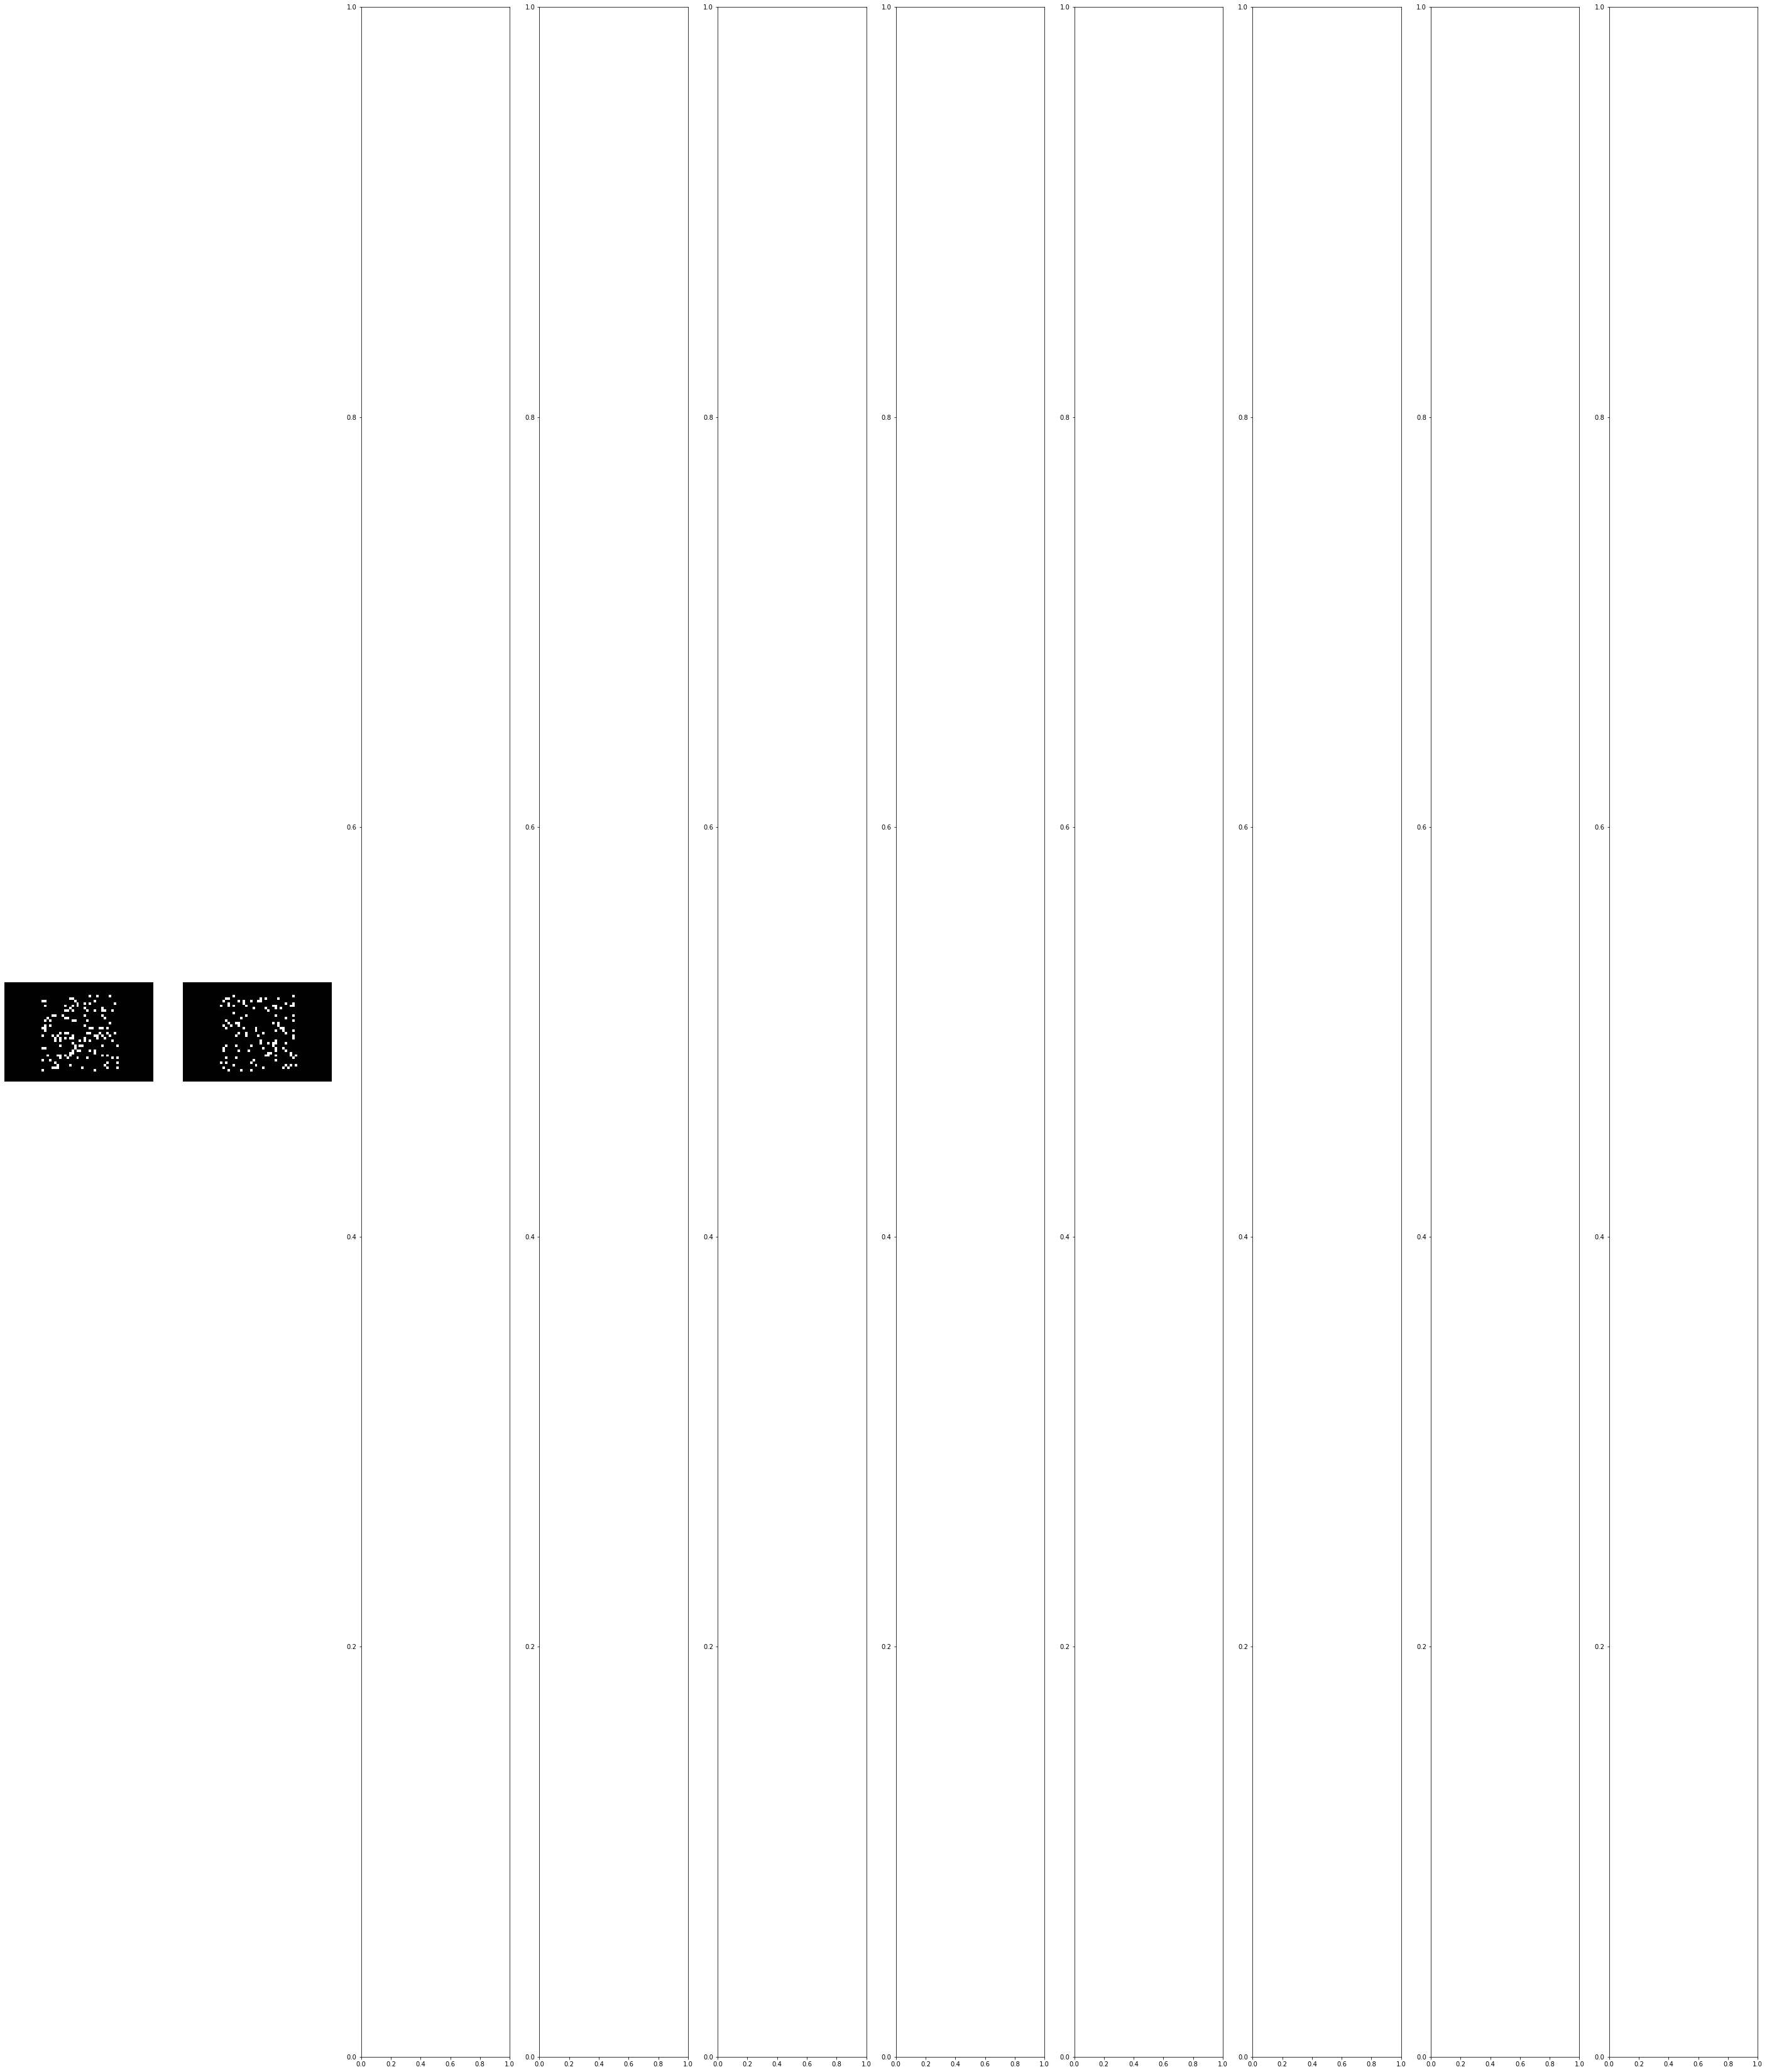

In [8]:
n = 10
f, axes = plt.subplots(1, n, figsize=(50, 60))
for i in range(n):
    index = random.randint(0, 1000)
    axes[i].imshow(classB[index], cmap='gray', interpolation='nearest')
    axes[i].axis('off')
    
plt.show()

In [9]:
# creating labels of data
classA_label = np.zeros(1000)
classB_label = np.ones(1000)
print(classA_label.shape)
print(classB_label.shape)

(1000,)
(1000,)


In [10]:
# make a dataset
class ImageDataset(Dataset):
    def __init__(self, data, targets, transform):
        self.sample = data
        self.targets = targets
        self.transform = transform
    
    
    def __len__(self): return len(self.sample)
    
    
    def __getitem__(self, idx):
        image = self.sample[idx, :, :]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return (
            image,
            torch.tensor(label, dtype=torch.int)
        )

In [11]:
# converting 2D grayscale image matrix to 3D image (like RGB)  
images = np.concatenate((classA, classB), axis=0)
print(images.shape)
images = np.repeat(images[:, :, :, None], 3, axis=3)
labels = np.concatenate((classA_label, classB_label), axis=0)
images = images.astype(np.uint8)
print(images.shape)
print(labels.shape)

(2000, 40, 60)
(2000, 40, 60, 3)
(2000,)


In [12]:
# check the normalization and Resize
from torchvision import transforms 
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = ImageDataset(data=images, targets=labels, transform=transform)
train_set, val_set = random_split(dataset, [1600, 400])
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
i = 0
for x, y in train_loader:
    # print(x[0, 0, :, :])
    print(x.size())
    print(type(y))
    break

torch.Size([64, 3, 224, 224])
<class 'torch.Tensor'>


C:\Users\Ulan\AppData\Local\Temp/ipykernel_20264/3191651169.py:21: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor(label, dtype=torch.int)


In [12]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model_base = EfficientNet.from_pretrained('efficientnet-b2')
        self.fc =  torch.nn.Sequential(
            nn.Linear(1000, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 256), 
            nn.Dropout(0.5),
            nn.ReLU(), 
            nn.Linear(256, 1), 
        )
    
    def forward(self, x):
        x = self.model_base(x)
        return self.fc(x)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
effb2_model = Model().to(device)

Loaded pretrained weights for efficientnet-b2


In [15]:
for name, param in effb2_model.named_parameters():
    if 'fc' not in name:
        param.requires_grad=False

for name, param in effb2_model.named_parameters():  
    print(name,param.requires_grad)

model_base._conv_stem.weight False
model_base._bn0.weight False
model_base._bn0.bias False
model_base._blocks.0._depthwise_conv.weight False
model_base._blocks.0._bn1.weight False
model_base._blocks.0._bn1.bias False
model_base._blocks.0._se_reduce.weight False
model_base._blocks.0._se_reduce.bias False
model_base._blocks.0._se_expand.weight False
model_base._blocks.0._se_expand.bias False
model_base._blocks.0._project_conv.weight False
model_base._blocks.0._bn2.weight False
model_base._blocks.0._bn2.bias False
model_base._blocks.1._depthwise_conv.weight False
model_base._blocks.1._bn1.weight False
model_base._blocks.1._bn1.bias False
model_base._blocks.1._se_reduce.weight False
model_base._blocks.1._se_reduce.bias False
model_base._blocks.1._se_expand.weight False
model_base._blocks.1._se_expand.bias False
model_base._blocks.1._project_conv.weight False
model_base._blocks.1._bn2.weight False
model_base._blocks.1._bn2.bias False
model_base._blocks.2._expand_conv.weight False
model_base

In [1]:
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        y_hat = effb2_model(x)
        print(type(x))
        break

NameError: name 'torch' is not defined

In [17]:
print(y)
print(y_hat.squeeze())

tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0], dtype=torch.int32)
tensor([ 0.0066,  0.0093, -0.0369,  0.2102,  0.2272,  0.1217,  0.1952,  0.2781,
         0.1562,  0.1288,  0.1289,  0.0817,  0.3922,  0.1253,  0.1397,  0.1913,
         0.1208,  0.3423,  0.1280,  0.3293,  0.0657,  0.4190,  0.2041,  0.2374,
         0.2277,  0.1252,  0.1992,  0.1936,  0.1118,  0.2655,  0.3205,  0.0367,
         0.1761, -0.0714,  0.3654,  0.2440,  0.1334,  0.0300,  0.1163,  0.1060,
         0.0682,  0.0909, -0.0715,  0.1381,  0.1227,  0.0293,  0.0812,  0.4133,
         0.0947,  0.1962, -0.0552, -0.0783,  0.0589,  0.2217,  0.1196, -0.0187,
         0.1781, -0.0069,  0.0966,  0.3712, -0.0178,  0.0109, -0.0112,  0.2713],
       device='cuda:0')


In [18]:
from torchsummary import summary
summary(effb2_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [19]:
def train(model, num_epochs, train_dl, valid_dl, loss_fn, optimizer):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
            # forward propagation
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            # backward propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(effb2_model.parameters(), lr= 1e-4)
torch.manual_seed(1)
num_epochs = 200
hist = train(effb2_model, num_epochs, train_dl=train_loader, valid_dl=val_loader, loss_fn=loss_fn, optimizer=optimizer)

C:\Users\Lab311\AppData\Local\Temp\ipykernel_1644\3191651169.py:21: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor(label, dtype=torch.int)


Epoch 1 accuracy: 0.5050 val_accuracy: 0.4875
Epoch 2 accuracy: 0.5638 val_accuracy: 0.4875
Epoch 3 accuracy: 0.6844 val_accuracy: 0.4875
Epoch 4 accuracy: 0.7638 val_accuracy: 0.4875
Epoch 5 accuracy: 0.7981 val_accuracy: 0.5125
Epoch 6 accuracy: 0.8200 val_accuracy: 0.5125
Epoch 7 accuracy: 0.8400 val_accuracy: 0.5125
Epoch 8 accuracy: 0.8369 val_accuracy: 0.5125
Epoch 9 accuracy: 0.8631 val_accuracy: 0.5125
Epoch 10 accuracy: 0.8606 val_accuracy: 0.5125
Epoch 11 accuracy: 0.8587 val_accuracy: 0.5125
Epoch 12 accuracy: 0.8825 val_accuracy: 0.5125
Epoch 13 accuracy: 0.8700 val_accuracy: 0.5125
Epoch 14 accuracy: 0.8800 val_accuracy: 0.5125
Epoch 15 accuracy: 0.8825 val_accuracy: 0.5125
Epoch 16 accuracy: 0.8819 val_accuracy: 0.5125
Epoch 17 accuracy: 0.8894 val_accuracy: 0.5125
Epoch 18 accuracy: 0.8925 val_accuracy: 0.5125
Epoch 19 accuracy: 0.8844 val_accuracy: 0.5100
Epoch 20 accuracy: 0.8856 val_accuracy: 0.5150
Epoch 21 accuracy: 0.8938 val_accuracy: 0.5275
Epoch 22 accuracy: 0.8

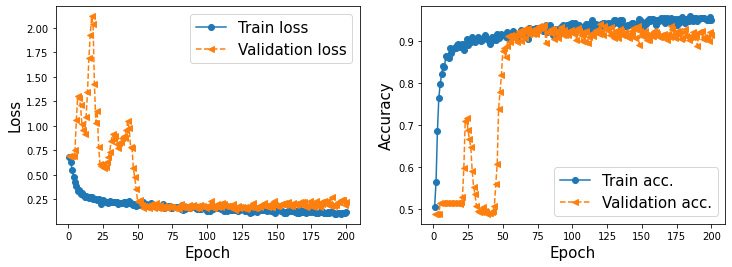

In [21]:
x = np.arange(1, num_epochs+1)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x, hist[0], '-o', label='Train loss')
ax.plot(x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x, hist[2], '-o', label='Train acc.')
ax.plot(x, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
#plt.savefig('figures/14_13.png')
plt.show()

In [22]:
torch.save(effb2_model.state_dict(), 'model_for_object1_2.pth')

In [23]:
effb2_model

Model(
  (model_base): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
 

In [24]:
model = Model()
model.load_state_dict(torch.load('model_for_object1_2.pth'))
model.eval()

Loaded pretrained weights for efficientnet-b2


Model(
  (model_base): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
 

In [50]:
model.to(device)
with torch.no_grad():
    predicted_train = torch.tensor([]).to(device)
    y_train = torch.tensor([]).to(device)
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        predicted = torch.round(torch.sigmoid(y_hat.squeeze()))
        y = torch.round(torch.sigmoid(y.squeeze()))
        predicted_train = torch.concat([predicted_train, predicted], dim=0)
        y_train = torch.concat([y_train, y], dim=0)
    print(predicted_train.size())
    print(y_train.size())

C:\Users\Lab311\AppData\Local\Temp\ipykernel_1644\3191651169.py:21: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor(label, dtype=torch.int)


torch.Size([1600])
torch.Size([1600])


In [51]:
with torch.no_grad():
    predicted_val = torch.tensor([]).to(device)
    y_val = torch.tensor([]).to(device)
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        predicted = torch.round(torch.sigmoid(y_hat.squeeze()))
        y = torch.round(torch.sigmoid(y.squeeze()))
        predicted_val = torch.concat([predicted_val, predicted], dim=0)
        y_val = torch.concat([y_val, y], dim=0)
    print(predicted_val.size())
    print(y_val.size())

C:\Users\Lab311\AppData\Local\Temp\ipykernel_1644\3191651169.py:21: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor(label, dtype=torch.int)


torch.Size([400])
torch.Size([400])


In [26]:
print(y)
predicted = torch.round(torch.sigmoid(y_hat.squeeze()))
print(predicted)

tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], dtype=torch.int32)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1.], device='cuda:0')


In [52]:
# visualizing a report
from sklearn.metrics import classification_report

target_names = ["class1", "class2"]
y_train = y_train.cpu().numpy()
predicted_train = predicted_train.cpu().numpy()
print(classification_report(y_train, predicted_train, target_names=target_names))


              precision    recall  f1-score   support

      class1       1.00      1.00      1.00       805
      class2       1.00      1.00      1.00       795

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [53]:
y_val = y_val.cpu().numpy()
predicted_val = predicted_val.cpu().numpy()
print(classification_report(y_val, predicted_val, target_names=target_names))

              precision    recall  f1-score   support

      class1       0.87      0.97      0.92       195
      class2       0.97      0.86      0.91       205

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



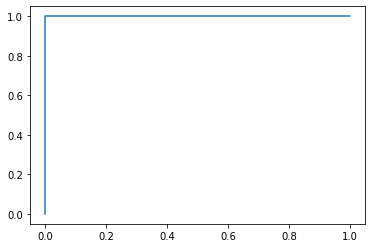

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve


fpr, tpr, _ = roc_curve(y_train, predicted_train)
score_roc_auc = roc_auc_score(y_train, predicted_train)

plt.plot(fpr, tpr, '-', label="algorithm" + '_' + 'dataset' + '(AUC = %0.4f)' % score_roc_auc)
plt.show()

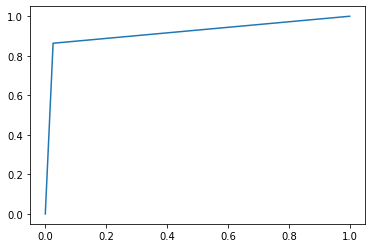

In [61]:
fpr, tpr, _ = roc_curve(y_val, predicted_val)
score_roc_auc = roc_auc_score(y_val, predicted_val)

plt.plot(fpr, tpr, '-', label="algorithm" + '_' + 'dataset' + '(AUC = %0.4f)' % score_roc_auc)
plt.show()